# Explore data loading
## Build a list of json files

In [1]:
import os

dirs_with_jsons = [
    '../data/raw/2020-03-13/biorxiv_medrxiv/biorxiv_medrxiv',
    '../data/raw/2020-03-13/comm_use_subset/comm_use_subset',
    '../data/raw/2020-03-13/noncomm_use_subset/noncomm_use_subset',
    '../data/raw/2020-03-13/pmc_custom_license/pmc_custom_license'
]

json_list = []

for dir_to_parse in dirs_with_jsons:
    for file in os.scandir(dir_to_parse):
        if file.name.split('.')[-1] == 'json':
            json_list.append(dir_to_parse + '/' + file.name)

## Lets see how many docs are here

In [2]:
len(json_list)

13202

## Load some text

In [3]:
import json

with open(json_list[0], 'r') as file:
    data = json.load(file)

In [4]:
data['body_text'][0]['text']

"In the absence of a curative treatment, the highly active antiretroviral therapy (HAART) keeps the HIV-1 virus of AIDS patients under control. HAART combines drugs targeting different stages of viral replication including the integration step catalyzed by the integrase protein (IN) (1) . Integration of viral DNA into host genome involves two steps catalyzed by IN: (i) cleavage of a dinucleotide from each 3'-end of the viral DNA (3'processing), and (ii) insertion of this processed viral DNA into the host DNA (strand-transfer) (2) . Clinical IN strand transfer inhibitors (INSTIs) target the catalytic site of the enzyme to specifically inhibit the DNA joining reaction, however, as with all anti-AIDS treatments, the continued success of these drugs is persistently disrupted by resistance mutations (1, 2) . Although 3'-processing can be carried out by monomeric IN (3) , the assembly of IN functional multimers is imperative for the strand-transfer activity (4) (5) (6) (7) (8) , and for viru

## Let's remove the references

In [5]:
import re

regex = "\([\d, i]+\)"
re.sub(regex, '', data['body_text'][0]['text'])

"In the absence of a curative treatment, the highly active antiretroviral therapy (HAART) keeps the HIV-1 virus of AIDS patients under control. HAART combines drugs targeting different stages of viral replication including the integration step catalyzed by the integrase protein (IN)  . Integration of viral DNA into host genome involves two steps catalyzed by IN:  cleavage of a dinucleotide from each 3'-end of the viral DNA (3'processing), and  insertion of this processed viral DNA into the host DNA (strand-transfer)  . Clinical IN strand transfer inhibitors (INSTIs) target the catalytic site of the enzyme to specifically inhibit the DNA joining reaction, however, as with all anti-AIDS treatments, the continued success of these drugs is persistently disrupted by resistance mutations  . Although 3'-processing can be carried out by monomeric IN  , the assembly of IN functional multimers is imperative for the strand-transfer activity      , and for virus particle maturation and production 

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/v/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
from nltk.tokenize import sent_tokenize

sent_tokenize(data['body_text'][0]['text'])

['In the absence of a curative treatment, the highly active antiretroviral therapy (HAART) keeps the HIV-1 virus of AIDS patients under control.',
 'HAART combines drugs targeting different stages of viral replication including the integration step catalyzed by the integrase protein (IN) (1) .',
 "Integration of viral DNA into host genome involves two steps catalyzed by IN: (i) cleavage of a dinucleotide from each 3'-end of the viral DNA (3'processing), and (ii) insertion of this processed viral DNA into the host DNA (strand-transfer) (2) .",
 'Clinical IN strand transfer inhibitors (INSTIs) target the catalytic site of the enzyme to specifically inhibit the DNA joining reaction, however, as with all anti-AIDS treatments, the continued success of these drugs is persistently disrupted by resistance mutations (1, 2) .',
 "Although 3'-processing can be carried out by monomeric IN (3) , the assembly of IN functional multimers is imperative for the strand-transfer activity (4) (5) (6) (7) (

## Let's build a corpus for tf-idf

In [8]:
from tqdm.auto import tqdm

index = []
docs = []
for doc_file in tqdm(json_list, unit='Papers'):
    with open(doc_file, 'r') as file:
        data = json.load(file)
        
        for parragraph_data in data['body_text']:
            parragraph = re.sub("\([\d, i]+\)", '', parragraph_data['text']) + '\n'
            
            for sentence in sent_tokenize(parragraph):
                index.append([len(docs), data['paper_id'], data['metadata']['title'], sentence])
                docs.append(sentence)

In [9]:
import pandas as pd

sentence_index = pd.DataFrame(index, columns=['sentence_id', 'paper_id', 'paper_title', 'sentence'])

In [10]:
sentence_index.sample(n=5)

,sentence_id,paper_id,paper_title,sentence
472257,472257,9b5a336dab77072af21829b37a7b8318ae1dec6d,The 17th Rocky Mountain Virology Association M...,Treatment with 12 µM of imatinib reduced the p...
209454,209454,5c4dfdf8ee6230324845b917be55c47d1e991f2c,hCLE/C14orf166 Associates with DDX1-HSPC117-FA...,Western blotting was carried out as described ...
1931928,1931928,9d651ee3cc003d22f9ffff68394494087112ec45,Complete viral RNA genome sequencing of ultra-...,"For Ovation RNA-Seq version 1 reactions, no sh..."
363783,363783,a5293bb4f17ad25a72133cdd9eee8748dd6a4b8d,A1 Pirfenidone inhibits TGF-b1-induced extrace...,Methods: ASCs were injected intravenously in w...
586240,586240,83b302c75378ce58e35ef93b6214a6ec330998c1,Modeling pathogenesis of emergent and pre-emer...,2015 Menachery et al.


In [11]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(docs)

In [12]:
transformer = TfidfTransformer()
pcount = transformer.fit_transform(counts)

In [13]:
dcounts = counts.sum(axis=0)[0]

In [38]:
word_usages = pd.DataFrame({'wcount': dcounts.tolist()[0], 'word': vectorizer.get_feature_names()})

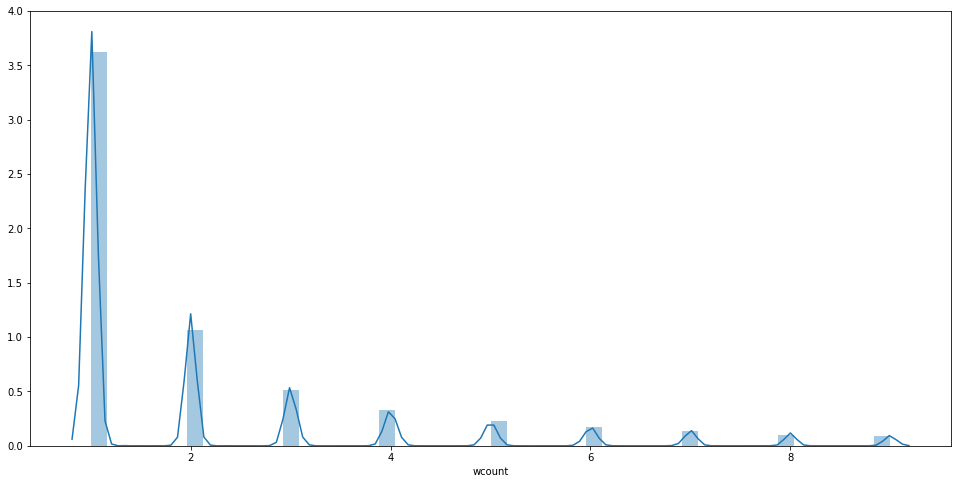

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dist(row, limit = None, title = None):
    fig = plt.figure(figsize=(16.5, 8))
    sns.distplot(row, bins=50)
    
    if limit:
        plt.axvline(limit, label="", color='tab:green')
        stats = '{} < {} < {}'.format(sum(row < limit), limit, sum(row > limit))
        ylim = fig.axes[0].get_ylim()
        yloc = ((ylim[1] - ylim[0]) * .8) - ylim[0]
        plt.annotate(stats, (limit, yloc), fontsize='large', horizontalalignment='center')
        
    if title:
        plt.title(title)
    
    plt.show()

    
plot_dist(word_usages.query('wcount < 10').wcount)

In [52]:
word_usages.query('2 < wcount').sort_values(by='wcount')

,wcount,word
298301,3,reconvene
182378,3,idis
57303,3,arstila
365134,3,vandenberg
124148,3,dunstan
...,...,...
349742,1110975,to
186566,1403951,in
51532,1731044,and
255754,2042328,of


# Stop point

1. We have our docs ready at `docs` for BERT vectorization if we where at pytorch, we will calculate the sentence ponderated average in GPU. But we are on tensor
2. We have to code a recoverable way for word to vector in BERT which handle gracefully not found words.
3. Then, we can add a ponderated average vector to `index` dataframe

# Auxiliary cells (used on the build of others)

In [18]:
# Exploring json structure

def print_keys(dict_to_traverse: dict, indent = ''):
    for key, value in dict_to_traverse.items():
        print(f'{indent}{key}')
        if type(value) == dict:
            print_keys(value, f'-{indent}')

print_keys(data)

paper_id
metadata
-title
-authors
abstract
body_text
bib_entries
-BIBREF0
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF1
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF2
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF3
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF4
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF5
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF6
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF7
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF8
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF9
--ref_id
--title
--authors
--year
--venue
--volume
--issn
--pages
--other_ids
-BIBREF10
--ref_id
--title
--authors
--year
--venue
--volume
--is